<a href="https://colab.research.google.com/github/Matheus-brazao/Transfer-Learning-for-AI-Dataset-Analysis/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TF version: 2.19.0


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.YZL5HL_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Classes: ['cat', 'dog'] | NUM_CLASSES: 2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4989 - loss: 6.3648 - val_accuracy: 0.5000 - val_loss: 1.6676
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4527 - loss: 1.2342 - val_accuracy: 0.5000 - val_loss: 0.8472
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 142s 30s/step - accuracy: 0.6181 - loss: 71.2093 - val_accuracy: 0.7812 - val_loss: 5.9009
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 139s 30s/step - accuracy: 0.9556 - loss: 1.1549 - val_accuracy: 0.9531 - val_loss: 1.3713


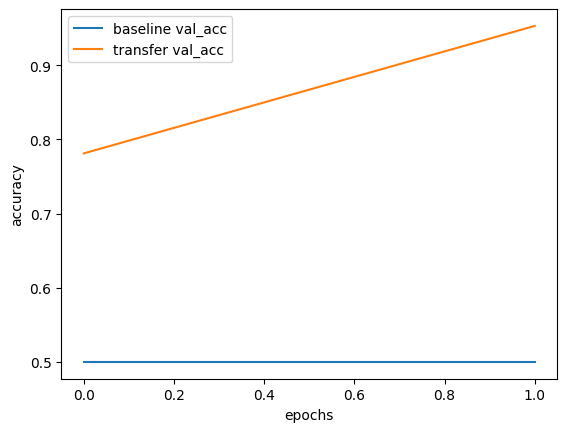

Baseline test (subset):
[0.6010914444923401, 0.75]
Transfer test (subset):
[2.3710923194885254, 0.9375]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


AttributeError: `ptp` was removed from the ndarray class in NumPy 2.0. Use np.ptp(arr, ...) instead.

In [ ]:
# =========================
# Section 0 — Setup & Imports
# =========================
# Original: import keras (standalone, legacy), manual loaders
# Update: use TF 2.x (tf.keras), with TFDS or directory loader

import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

print("TF version:", tf.__version__)

# ================
# Section 1 — Config
# ================
# Change this to switch dataset quickly:
# - "tfds:cats_vs_dogs" (uses TFDS)
# - "dir:/content/drive/MyDrive/my_dataset" (directory with subfolders per class)
DATA_SOURCE = "tfds:cats_vs_dogs"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# FAST_MODE: tiny run for quick sanity-check (few batches/epochs)
FAST_MODE = True
EPOCHS_BASELINE = 2 if FAST_MODE else 5
EPOCHS_TRANSFER = 2 if FAST_MODE else 5
STEPS_PER_EPOCH = 5 if FAST_MODE else 100
VAL_STEPS = 2 if FAST_MODE else 30
TEST_STEPS = 2 if FAST_MODE else 50

AUTOTUNE = tf.data.AUTOTUNE


# ==========================================
# Section 2 — Dataset loaders (TFDS or folder)
# ==========================================
def preprocess_baseline(image, label):
    # Baseline: simple [0,1] normalization
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_for_vgg(image, label):
    # VGG16 expects its own preprocess_input
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)  # will be scaled by preprocess_input
    image = preprocess_input(image)     # center/scale as VGG16 expects
    return image, label

def load_tfds(name="cats_vs_dogs"):
    (ds_train, ds_val, ds_test), info = tfds.load(
        name,
        split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
        as_supervised=True,
        with_info=True
    )
    num_classes = info.features["label"].num_classes
    class_names = info.features["label"].names
    return ds_train, ds_val, ds_test, num_classes, class_names

def load_from_directory(dir_path):
    # Directory structure:
    # dir_path/
    #   class_a/ img1.jpg ...
    #   class_b/ ...
    train = tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        validation_split=0.2, subset="training", seed=SEED,
        image_size=IMG_SIZE, batch_size=BATCH_SIZE
    )
    val = tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        validation_split=0.2, subset="validation", seed=SEED,
        image_size=IMG_SIZE, batch_size=BATCH_SIZE
    )
    class_names = train.class_names
    num_classes = len(class_names)
    # Create a small test set from val (quick hack for demo)
    test = val.unbatch().batch(BATCH_SIZE)
    return train, val, test, num_classes, class_names

def build_pipelines(DATA_SOURCE):
    if DATA_SOURCE.startswith("tfds:"):
        name = DATA_SOURCE.split("tfds:")[1]
        ds_train, ds_val, ds_test, num_classes, class_names = load_tfds(name)
        # Two parallel pipelines: baseline and transfer (different preprocessing)
        train_base = ds_train.map(preprocess_baseline, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
        val_base   = ds_val.map(preprocess_baseline,   num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_base  = ds_test.map(preprocess_baseline,  num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

        train_vgg = ds_train.map(preprocess_for_vgg, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
        val_vgg   = ds_val.map(preprocess_for_vgg,   num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_vgg  = ds_test.map(preprocess_for_vgg,  num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

    elif DATA_SOURCE.startswith("dir:"):
        dir_path = DATA_SOURCE.split("dir:")[1]
        raw_train, raw_val, raw_test, num_classes, class_names = load_from_directory(dir_path)

        # Baseline pipelines
        train_base = raw_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y)).cache().prefetch(AUTOTUNE)
        val_base   = raw_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y)).cache().prefetch(AUTOTUNE)
        test_base  = raw_test.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y)).cache().prefetch(AUTOTUNE)

        # VGG pipelines
        train_vgg = raw_train.map(lambda x,y: (preprocess_input(tf.cast(x, tf.float32)), y)).cache().prefetch(AUTOTUNE)
        val_vgg   = raw_val.map(lambda x,y: (preprocess_input(tf.cast(x, tf.float32)), y)).cache().prefetch(AUTOTUNE)
        test_vgg  = raw_test.map(lambda x,y: (preprocess_input(tf.cast(x, tf.float32)), y)).cache().prefetch(AUTOTUNE)

    else:
        raise ValueError("DATA_SOURCE must start with 'tfds:' or 'dir:'")

    # FAST subsets (few steps) for quick runs
    train_base_small = train_base.take(STEPS_PER_EPOCH)
    val_base_small   = val_base.take(VAL_STEPS)
    test_base_small  = test_base.take(TEST_STEPS)

    train_vgg_small = train_vgg.take(STEPS_PER_EPOCH)
    val_vgg_small   = val_vgg.take(VAL_STEPS)
    test_vgg_small  = test_vgg.take(TEST_STEPS)

    return (train_base_small, val_base_small, test_base_small,
            train_vgg_small,  val_vgg_small,  test_vgg_small,
            num_classes, class_names)

(train_base, val_base, test_base,
 train_vgg,  val_vgg,  test_vgg,
 NUM_CLASSES, CLASS_NAMES) = build_pipelines(DATA_SOURCE)

print("Classes:", CLASS_NAMES, "| NUM_CLASSES:", NUM_CLASSES)


# =========================================
# Section 3 — Baseline model (from scratch)
# =========================================
def build_baseline(input_shape=IMG_SIZE+(3,), num_classes=2):
    model = Sequential([
        Conv2D(32, 3, activation="relu", input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, 3, activation="relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

baseline = build_baseline(num_classes=NUM_CLASSES)
baseline.summary()

history_base = baseline.fit(
    train_base,
    validation_data=val_base,
    epochs=EPOCHS_BASELINE,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    verbose=1
)


# =========================================
# Section 4 — Transfer learning (VGG16)
# =========================================
# Original: include_top=True then swap last Dense.
# Update: include_top=False and add our 2-class head.

base_model = VGG16(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
for layer in base_model.layers:
    layer.trainable = False  # freeze feature extractor

inputs = tf.keras.Input(shape=IMG_SIZE+(3,))
x = inputs
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

transfer_model = Model(inputs, outputs, name="vgg16_transfer")
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])
transfer_model.summary()

history_transfer = transfer_model.fit(
    train_vgg,
    validation_data=val_vgg,
    epochs=EPOCHS_TRANSFER,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    verbose=1
)


# =========================================
# Section 5 — Quick comparison & test eval
# =========================================
plt.plot(history_base.history["val_accuracy"], label="baseline val_acc")
plt.plot(history_transfer.history["val_accuracy"], label="transfer val_acc")
plt.xlabel("epochs"); plt.ylabel("accuracy"); plt.legend(); plt.show()

print("Baseline test (subset):")
print(baseline.evaluate(test_base, verbose=0))

print("Transfer test (subset):")
print(transfer_model.evaluate(test_vgg, verbose=0))


# =========================================
# Section 6 — Tiny manual prediction (2 images)
# =========================================
# Take just 2 samples from the test_vgg pipeline and predict
for images, labels in test_vgg.take(1):
    preds = transfer_model.predict(images[:2])
    import numpy as np
    pred_ids = np.argmax(preds, axis=1)
    for i in range(2):
        plt.imshow((images[i].numpy() - images[i].numpy().min()) / (np.ptp(images[i].numpy()) + 1e-6))
        plt.title(f"Pred: {CLASS_NAMES[pred_ids[i]]} | True: {CLASS_NAMES[int(labels[i])]}")
        plt.axis("off")
        plt.show()
